In [44]:
import torch 
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
device

'cuda'

In [145]:
transformer = transforms.Compose([
    
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [146]:
datalink = "/kaggle/input/celeba-dataset/img_align_celeba"
dataset = datasets.ImageFolder(datalink, transform=transformer)

In [147]:
len(dataset)

202599

In [148]:
dataset, _ = random_split(dataset, [0.1, 0.9])

In [150]:
train_data, val_data = random_split(dataset, [0.9, 0.1])

In [151]:
def output(limit, data):
    for i, (x, _) in enumerate(data):
        x = x.permute(1, 2, 0).cpu().numpy()
        plt.imshow(x)
        plt.show()
    
        if i >= limit:
            break

In [152]:
len(train_data)

18234

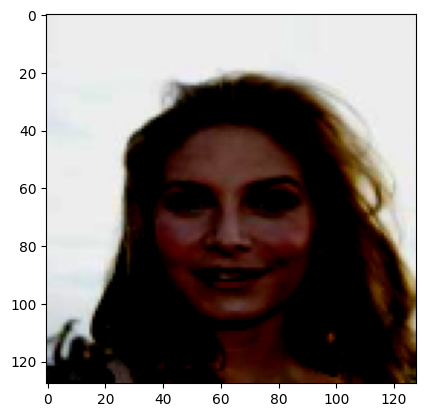

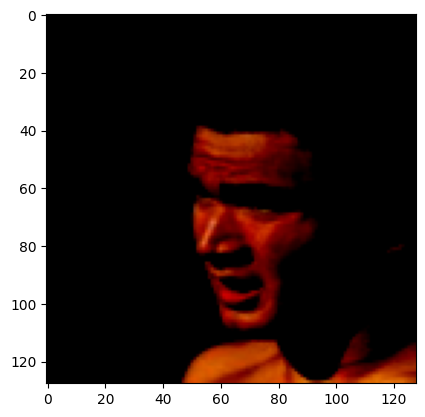

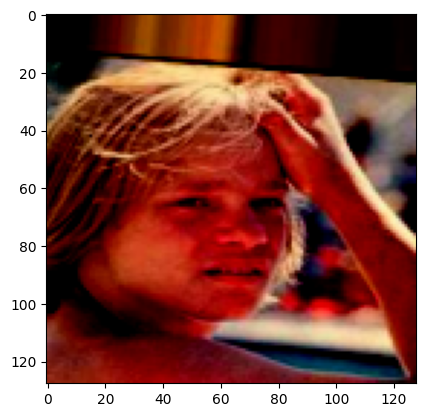

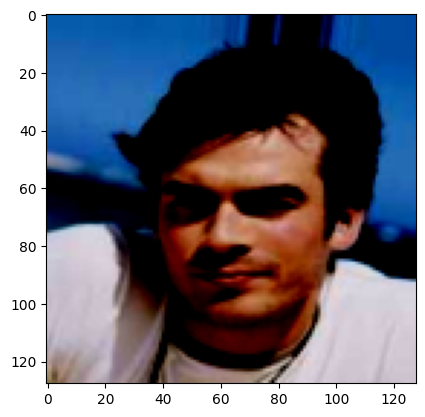

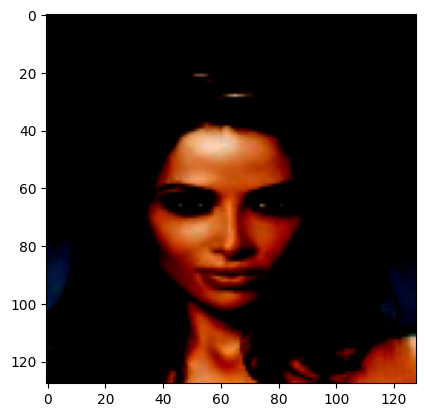

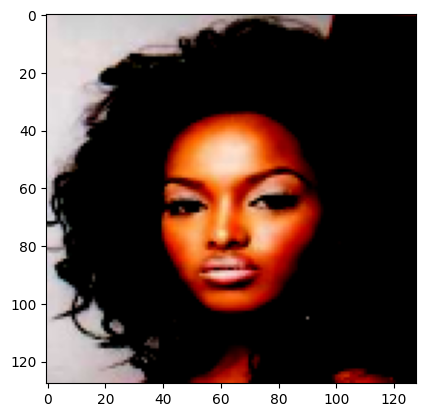

In [154]:
 output(5, train_data)

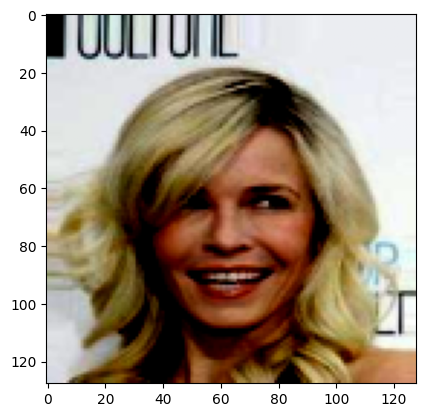

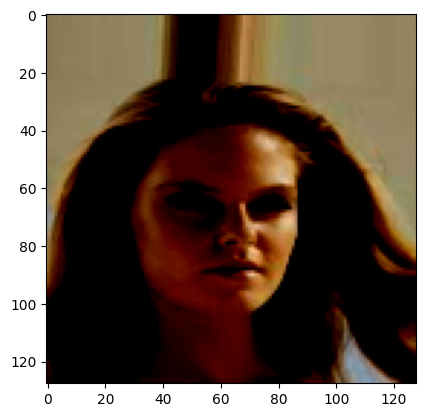

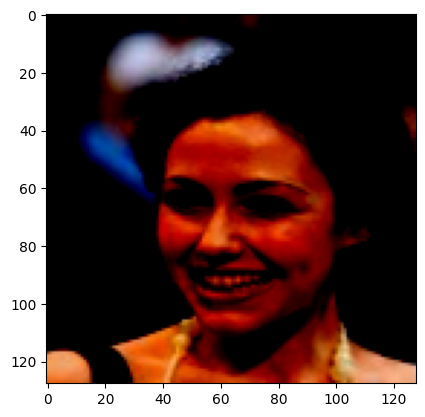

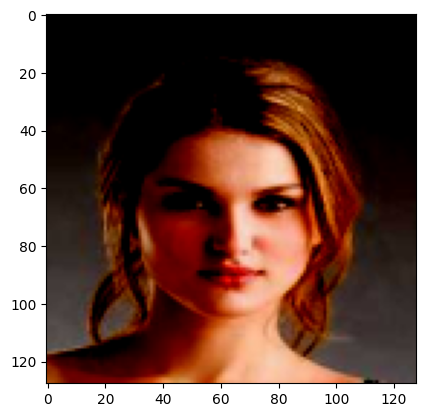

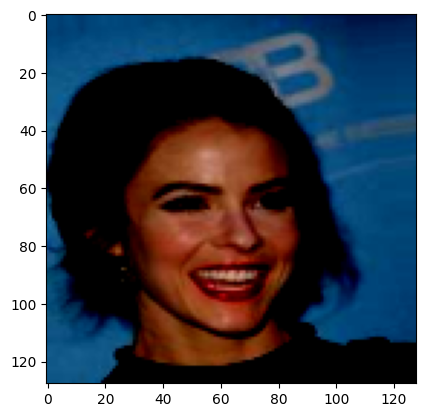

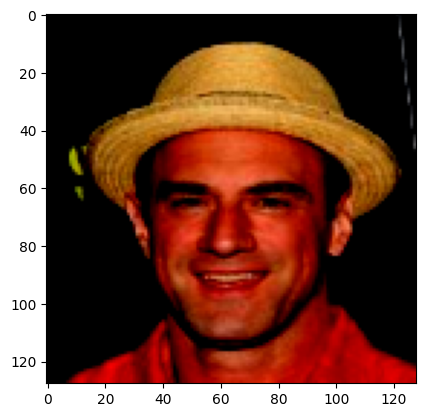

In [155]:
output(5, val_data)

In [156]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
val_dl = DataLoader(val_data, batch_size=64, shuffle=False)

In [158]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.add_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = F.relu(self.bnorm1(self.conv1(x)))
        add_out = self.add_conv(x)
        
        out = F.relu(self.bnorm2(self.conv2(out)))

        out = out + add_out

        return out

In [159]:
block = SkipBlock(1024, 512, 4, 2, 1)
block.to(device)

tensor = torch.rand(1, 1024, 2, 2).to(device)
out = block(tensor)
out.shape

torch.Size([1, 512, 4, 4])

In [160]:
1024*2*2,
512*4*4

8192

In [162]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.linear1 = nn.Linear(128, 512)
        self.bnorm_1 = nn.BatchNorm1d(512)
        
        # self.linear2 = nn.Linear(256, 512)
        # self.bnorm_2 = nn.BatchNorm1d(512)
        
        # self.linear3 = nn.Linear(512, 1024)
        # self.bnorm_3 = nn.BatchNorm1d(1024)
        
        self.linear4 = nn.Linear(512, 512*2*2)
        self.bnorm_4 = nn.BatchNorm1d(512*2*2)

        self.unflatten = nn.Unflatten(1, (512, 2, 2))

        self.conv1 = SkipBlock(512, 256, 4, 2, 1)
        self.conv2 = SkipBlock(256, 128, 4, 2, 1)
        self.conv3 = SkipBlock(128, 64, 4, 2, 1)
        self.conv4 = SkipBlock(64, 32, 4, 2, 1)

        self.conv5 = SkipBlock(32, 32, 4, 2, 1)
        # self.conv6 = SkipBlock(32, 3, 4, 2, 1)
        self.conv6 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)


        

    def forward(self, x):
        out = F.relu(self.bnorm_1(self.linear1(x)))
        # out = F.relu(self.bnorm_2(self.linear2(out)))
        # out = F.relu(self.bnorm_3(self.linear3(out)))
        out = F.relu(self.bnorm_4(self.linear4(out)))
        out = self.unflatten(out)

        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        out = self.conv5(out)
        out = F.tanh(self.conv6(out))
        return out

In [174]:
generator = Generator()
generator.to(device)

generator.eval()

tensor = torch.randn(1, 128).to(device)
out = generator(tensor)
out.shape

torch.Size([1, 3, 128, 128])

In [175]:
summary(generator, input_size=(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          66,048
       BatchNorm1d-2                  [-1, 512]           1,024
            Linear-3                 [-1, 2048]       1,050,624
       BatchNorm1d-4                 [-1, 2048]           4,096
         Unflatten-5            [-1, 512, 2, 2]               0
   ConvTranspose2d-6            [-1, 256, 4, 4]       2,097,408
       BatchNorm2d-7            [-1, 256, 4, 4]             512
   ConvTranspose2d-8            [-1, 256, 4, 4]       2,097,408
       BatchNorm2d-9            [-1, 256, 4, 4]             512
  ConvTranspose2d-10            [-1, 256, 4, 4]         590,080
      BatchNorm2d-11            [-1, 256, 4, 4]             512
        SkipBlock-12            [-1, 256, 4, 4]               0
  ConvTranspose2d-13            [-1, 128, 8, 8]         524,416
      BatchNorm2d-14            [-1, 12

In [165]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bnorm4 = nn.BatchNorm2d(256)
        
        

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(256*8*8, 256)
        # self.bnorm_1 = nn.BatchNorm1d(256)
        # self.dropout1 = nn.Dropout(0.6)
        
        self.linear2 = nn.Linear(256, 64)
        # self.dropout2 = nn.Dropout(0.4)
        # self.bnorm_2 = nn.BatchNorm1d(64)
        
        self.linear3 = nn.Linear(64, 1)
     
        

    def forward(self, x):
        out = F.relu(self.bnorm1(self.conv1(x)))
        out = F.relu(self.bnorm2(self.conv2(out)))
        out = F.relu(self.bnorm3(self.conv3(out)))
        out = F.relu(self.bnorm4(self.conv4(out)))
        # out = F.relu(self.bnorm5(self.conv5(out)))

        out = self.flatten(out)

        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        # using nn.BCELossWithLogits we dont need additional activation function 
        # on the last layer of discriminator
        out = self.linear3(out)
        
        return out
        
        

In [176]:
discriminator = Discriminator()
discriminator.to(device)
discriminator.eval()

tensor = torch.rand(1, 3, 128, 128).to(device)
out = discriminator(tensor)
out.shape

torch.Size([1, 1])

In [177]:
summary(discriminator, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 32, 32]          65,600
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5          [-1, 128, 16, 16]         131,200
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7            [-1, 256, 8, 8]         524,544
       BatchNorm2d-8            [-1, 256, 8, 8]             512
           Flatten-9                [-1, 16384]               0
           Linear-10                  [-1, 256]       4,194,560
           Linear-11                   [-1, 64]          16,448
           Linear-12                    [-1, 1]              65
Total params: 4,936,577
Trainable params: 4,936,577
Non-trainable params: 0
---------------------------

In [178]:
# adv_loss = nn.BCELoss()

# thise one ose BCELoss() with built-in sigmoida function
adv_loss = nn.BCEWithLogitsLoss()


optimizer_G = AdamW(generator.parameters(), lr=1e-3, weight_decay=1e-3, betas=(0.5, 0.999))
optimizer_D = AdamW(discriminator.parameters(), lr=1e-3, weight_decay=1e-3, betas=(0.5, 0.999))

In [179]:
def train(generator, discriminator, adv_loss, train_dl, optimizer_G, optimizer_D, epochs, device, G_step):
    history = {
        "G_loss": [],
        "D_loss": []
    }

    
    # torch.autograd.set_detect_anomaly(True)

    
    for epoch in range(epochs):

        generator.train()
        discriminator.train()

        G_loss = 0.0
        D_loss = 0.0 
        
        for x, _ in tqdm(train_dl):
            x = x.to(device)
            
            # reals = torch.ones(x.size(0), 1).to(device)
            reals = torch.full((x.size(0), 1), 0.9, device=device)
            fakes = torch.zeros(x.size(0), 1).to(device)

            optimizer_D.zero_grad()

            real_loss = adv_loss(discriminator(x), reals)

            z = torch.randn(x.size(0), 128).to(device)
            
            gen_img = generator(z)

            fake_loss = adv_loss(discriminator(gen_img.detach()), fakes)

            d_loss = fake_loss + real_loss / 2
            d_loss.backward()
            optimizer_D.step()

            D_loss += d_loss.item()

            for i in range(G_step):
                optimizer_G.zero_grad()
    
                z = torch.randn(x.size(0), 128).to(device)
                gen_img = generator(z)
        
                g_loss = adv_loss(discriminator(gen_img), reals)
                g_loss.backward()
                optimizer_G.step()
        
                G_loss += g_loss.item()

        fin_G_loss = G_loss / len(train_dl)
        fin_D_loss = D_loss / len(train_dl)

        history["G_loss"].append(fin_G_loss)
        history["D_loss"].append(fin_D_loss)

        print(f"Epoch: {epoch+1}, Generator_loss: {fin_G_loss:.4f}, Discriminator_loss: {fin_D_loss:.4f}")

    return history

    
                
    

In [180]:
history = train(generator, discriminator, adv_loss, train_dl, optimizer_G, optimizer_D, 30, device, 2)

100%|██████████| 285/285 [01:53<00:00,  2.51it/s]


Epoch: 1, Generator_loss: 4.3367, Discriminator_loss: 0.8413


100%|██████████| 285/285 [01:36<00:00,  2.95it/s]


Epoch: 2, Generator_loss: 3.1709, Discriminator_loss: 0.8915


100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


Epoch: 3, Generator_loss: 2.8682, Discriminator_loss: 0.8996


100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


Epoch: 4, Generator_loss: 2.7357, Discriminator_loss: 0.9022


100%|██████████| 285/285 [01:37<00:00,  2.93it/s]


Epoch: 5, Generator_loss: 2.6795, Discriminator_loss: 0.9041


100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


Epoch: 6, Generator_loss: 2.6774, Discriminator_loss: 0.9046


100%|██████████| 285/285 [01:37<00:00,  2.93it/s]


Epoch: 7, Generator_loss: 2.4562, Discriminator_loss: 0.9155


100%|██████████| 285/285 [01:36<00:00,  2.94it/s]


Epoch: 8, Generator_loss: 2.3976, Discriminator_loss: 0.9162


100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


Epoch: 9, Generator_loss: 2.3323, Discriminator_loss: 0.9198


100%|██████████| 285/285 [01:36<00:00,  2.96it/s]


Epoch: 10, Generator_loss: 2.2681, Discriminator_loss: 0.9189


100%|██████████| 285/285 [01:36<00:00,  2.96it/s]


Epoch: 11, Generator_loss: 2.2619, Discriminator_loss: 0.9190


100%|██████████| 285/285 [01:37<00:00,  2.93it/s]


Epoch: 12, Generator_loss: 2.2321, Discriminator_loss: 0.9195


100%|██████████| 285/285 [01:36<00:00,  2.96it/s]


Epoch: 13, Generator_loss: 2.2350, Discriminator_loss: 0.9187


100%|██████████| 285/285 [01:36<00:00,  2.96it/s]


Epoch: 14, Generator_loss: 2.2276, Discriminator_loss: 0.9188


100%|██████████| 285/285 [01:35<00:00,  2.98it/s]


Epoch: 15, Generator_loss: 2.2289, Discriminator_loss: 0.9182


100%|██████████| 285/285 [01:35<00:00,  2.97it/s]


Epoch: 16, Generator_loss: 2.2305, Discriminator_loss: 0.9177


100%|██████████| 285/285 [01:35<00:00,  2.97it/s]


Epoch: 17, Generator_loss: 2.2289, Discriminator_loss: 0.9177


100%|██████████| 285/285 [01:36<00:00,  2.94it/s]


Epoch: 18, Generator_loss: 2.2292, Discriminator_loss: 0.9174


100%|██████████| 285/285 [01:37<00:00,  2.94it/s]


Epoch: 19, Generator_loss: 2.2301, Discriminator_loss: 0.9171


100%|██████████| 285/285 [01:35<00:00,  2.98it/s]


Epoch: 20, Generator_loss: 2.2336, Discriminator_loss: 0.9168


100%|██████████| 285/285 [01:36<00:00,  2.94it/s]


Epoch: 21, Generator_loss: 2.2310, Discriminator_loss: 0.9170


100%|██████████| 285/285 [01:36<00:00,  2.96it/s]


Epoch: 22, Generator_loss: 2.2317, Discriminator_loss: 0.9167


100%|██████████| 285/285 [01:35<00:00,  2.99it/s]


Epoch: 23, Generator_loss: 2.2360, Discriminator_loss: 0.9165


100%|██████████| 285/285 [01:36<00:00,  2.97it/s]


Epoch: 24, Generator_loss: 2.2321, Discriminator_loss: 0.9166


100%|██████████| 285/285 [01:36<00:00,  2.97it/s]


Epoch: 25, Generator_loss: 2.2335, Discriminator_loss: 0.9165


100%|██████████| 285/285 [01:41<00:00,  2.80it/s]


Epoch: 26, Generator_loss: 2.2362, Discriminator_loss: 0.9164


100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch: 27, Generator_loss: 2.2368, Discriminator_loss: 0.9164


100%|██████████| 285/285 [01:43<00:00,  2.75it/s]


Epoch: 28, Generator_loss: 2.2375, Discriminator_loss: 0.9163


100%|██████████| 285/285 [01:45<00:00,  2.71it/s]


Epoch: 29, Generator_loss: 2.2387, Discriminator_loss: 0.9163


100%|██████████| 285/285 [01:38<00:00,  2.91it/s]

Epoch: 30, Generator_loss: 2.2580, Discriminator_loss: 0.9174


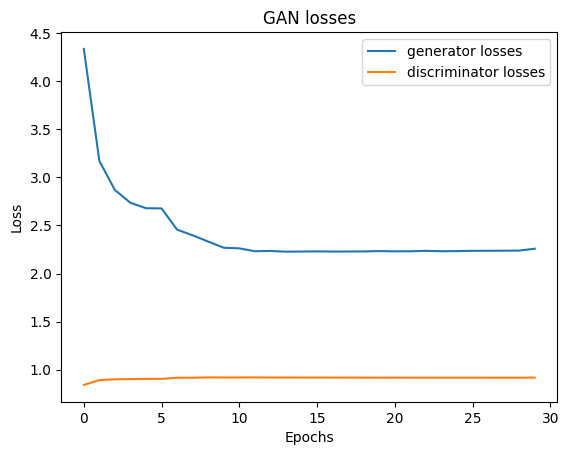

In [192]:
plt.plot(history["G_loss"], label="generator losses")
plt.plot(history["D_loss"], label="discriminator losses")
plt.title("GAN losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

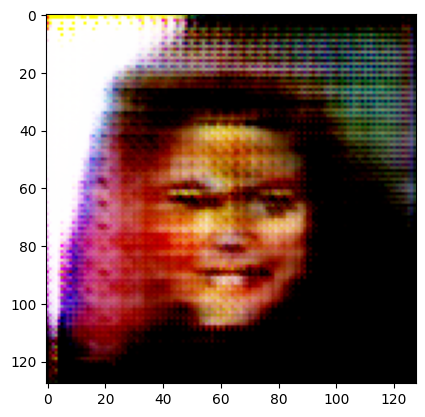

In [189]:
generator.eval()
tensor = torch.randn(1, 128).to(device)

with torch.no_grad():
    
    out = generator(tensor)
res = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(res)

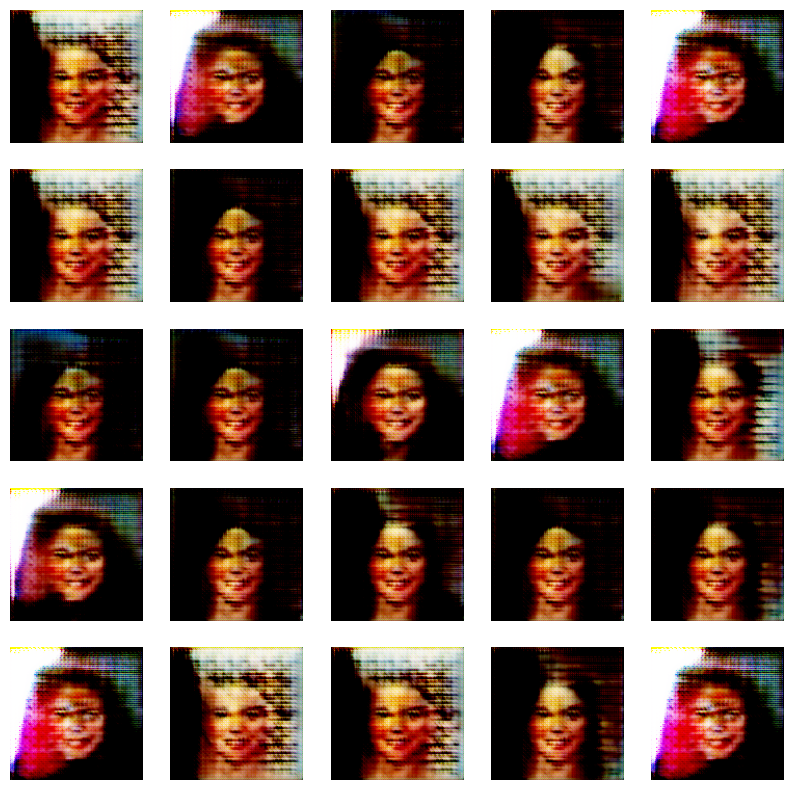

In [184]:
z = torch.rand(25, 128).to(device)
gen_imgs = generator(z)

gen_imgs = gen_imgs.squeeze().permute(0, 2, 3, 1).detach().cpu().numpy()


generator.eval()

with torch.no_grad():
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i])
        plt.axis("off")
    plt.show()

In [ ]:
torch.save(generator.load_state_dict(), "generatorV01.pt")
torch.save(discriminator.load_state_dict(), "discriminatorV01.pt")